In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot
import matplotlib
from flask import Flask, jsonify

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn=engine.connect()

In [6]:
# reflect an existing database into a new model
base=automap_base()
base.prepare(engine, reflect=True)
# reflect the tables


In [7]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = base.classes.measurement
station=base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [10]:
#create the datasets
station_data = pd.read_sql("SELECT * FROM station", conn)
measurement_data = pd.read_sql("SELECT * FROM measurement", conn)

# Exploratory Climate Analysis

Text(0.5, 0, 'Date (2016 to 2017)')

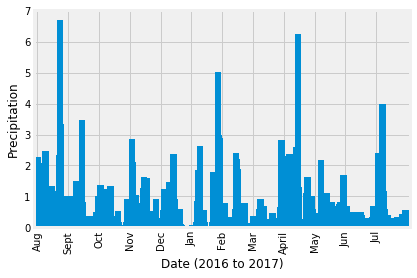

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#--- get the dates
datelist=session.query(measurement.date).\
    order_by(measurement.date).all()

#--------recent
lastdate=(max(datelist))[0]

#--------12 months beforehand
timeobject=datetime.strptime(lastdate, '%Y-%m-%d')
firstdate_obj=(timeobject-timedelta(days=365))
firstdate=str(firstdate_obj).split(" ")[0]

#---get data from those dates
data=session.query(measurement.date, measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", measurement.date) > firstdate,func.strftime("%Y-%m-%d", measurement.date) < lastdate ).all()
rain_data_noin = pd.DataFrame(data)
rain_data = pd.DataFrame(data).set_index("date")
sorted_df=rain_data.sort_values(by=['date'])


# Use Pandas Plotting with Matplotlib to plot the data
x_labels=("Aug","Sept","Oct","Nov","Dec","Jan","Feb", "Mar", "April", "May", "Jun", "Jul")
ticks=np.arange(len(sorted_df))
plot=sorted_df.plot(kind="bar", width=40, legend=False)
plot.locator_params(axis='x', nbins=12)
plot.set_xticklabels(x_labels, rotation=90)
plt.ylabel("Precipitation")
plt.xlabel("Date (2016 to 2017)")

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
mean_rain=sorted_df["prcp"].mean()
sd_rain=sorted_df['prcp'].std()
var_rain=sd_rain**2
max_rain=sorted_df["prcp"].max()
min_rain=sorted_df["prcp"].min()
quartile1=sorted_df['prcp'].quantile(q=0.25)
median_rain=sorted_df['prcp'].median()
quartile3=sorted_df['prcp'].quantile(q=0.75)

summary_stats = {
    'Mean':  [mean_rain],
    'SD': [sd_rain],
    'Min': [min_rain],
    'Max': [max_rain],
    'Quartile 1': [quartile1],
    'Quartile 2': [median_rain],
    'Quartile 3':[quartile3]}
summary_df = pd.DataFrame (summary_stats, columns = ['Mean','SD', "Min","Max","Quartile 1", "Quartile 2", "Quartile 3"])
summary_df

,Mean,SD,Min,Max,Quartile 1,Quartile 2,Quartile 3
0,0.176549,0.460667,0.0,6.7,0.0,0.02,0.13


In [13]:
# Design a query to show how many stations are available in this dataset
station_count = pd.read_sql("SELECT station, count(station) FROM measurement WHERE station NOT NULL GROUP BY station ORDER BY count(station) DESC", conn)
station_totals=pd.DataFrame(station_count)
print(f"There are {len(station_count)} stations in this dataset.")

There are 9 stations in this dataset.


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

max_count=station_count["count(station)"].max()
max_row=station_count.loc[station_count["count(station)"]==max_count]
maxno=str(max_row["station"])
maxno=maxno.split(" ")[4]
maxno=maxno.split("\n")
maxno=maxno[0]
maxno

min_count=station_count["count(station)"].min()
min_row=station_count.loc[station_count["count(station)"]==min_count]
minno=str(min_row["station"])
minno=minno.split(" ")[4]
minno=minno.split("\n")
minno=minno[0]
minno


#new.loc[new["Timepoint"]==timepoints[0]]
#min_count=station_count["count(station)"].min()
print(f"The most active station is {maxno} with {max_count} total measurements.")
print(f"The least active statement is {minno} with {min_count} total measurements.")

The most active station is USC00519281 with 2772 total measurements.
The least active statement is USC00518838 with 511 total measurements.


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
maxstation_df=measurement_data.loc[measurement_data["station"]==maxno]
min_temp=maxstation_df["tobs"].min()
max_temp=maxstation_df["tobs"].max()
avg_temp=maxstation_df["tobs"].mean()

active_stats = {
    'Station': [maxno],
    'Mean':  [avg_temp],
    'Min': [min_temp],
    'Max': [max_temp],}
active_df = pd.DataFrame (active_stats, columns = ['Station','Mean',"Min","Max"])
active_df

,Station,Mean,Min,Max
0,USC00519281,71.663781,54.0,85.0


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#create 
tempmos_df['temp_bracket'] = pd.cut(tempmos_df['tobs'], bins=12)
#station_count = pd.read_sql("SELECT station, count(station) FROM measurement WHERE tobs NOT NULL GROUP BY station ORDER BY count(station) DESC", conn)
tempmos_counts_df=tempmos_df.groupby(['temp_bracket']).count()
tempmos_counts_df=tempmos_counts_df[["station"]]
ticks=np.arange(len(tempmos_counts_df))


x_labels=("60"," "," ","65"," ","","70", " ", "75", " ", " ", "80")
xpos2=np.arange(len(tempmos_counts_df))
tick_locations=[value for value in xpos2]
plt.bar(xpos2, tempmos_counts_df["station"], color='r', alpha=0.5, align="center")
plt.xticks(tick_locations, x_labels, rotation="horizontal")
plt.title("Temperature Frequency")
plt.ylabel("Count")
plt.xlabel("Temperature Recorded")


NameError: name 'tempmos_df' is not defined

In [ ]:
#bin_labels = ['<60', '60s', '70s','80s','90s']
#bin_temps = [0, 60, 70, 80, 90, 100]
tempmos_df['temp_bracket'] = pd.cut(tempmos_df['tobs'], bins=12)

In [ ]:
station_count = pd.read_sql("SELECT station, count(station) FROM measurement WHERE tobs NOT NULL GROUP BY station ORDER BY count(station) DESC", conn)

In [ ]:
tempmos_df.to_csv('active_temp_data.csv')

In [ ]:
tempmos_counts_df=tempmos_df.groupby(['temp_bracket']).count()
tempmos_counts_df=tempmos_counts_df[["station"]]

In [ ]:

x_labels=("60"," "," ","65"," ","","70", " ", "75", " ", " ", "80")
ticks=np.arange(len(tempmos_counts_df))
tempplot=tempmos_counts_df.plot(kind="bar", legend=False)
plot.locator_params(axis='x', nbins=12)
plot.set_xticklabels(x_labels, rotation=90)
tick_locations=[value for value in ticks]
#plot.set_xticklabels(x_labels, rotation=90) #This is where the change should be made

xpos2=np.arange(len(tempmos_counts_df))
tick_locations=[value for value in xpos2]
plt.bar(xpos2, tempmos_counts_df["station"], color='r', alpha=0.5, align="center")
plt.xticks(tick_locations, x_labels, rotation="horizontal")
plt.title("Temperature Frequency")
plt.ylabel("Count")
plt.xlabel("Temperature Recorded")

In [ ]:
tempmos_counts_df

In [17]:
#pt 2: make an ap with flask

## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    #collect all dates
    alldates=session.query(measurement.date).\
    order_by(measurement.date).all()
    
    #get all data from those dates
    calc_temps=session.query(measurement.date, measurement.tobs).\
        filter(func.strftime("%Y-%m-%d", measurement.date) > start_date,func.strftime("%Y-%m-%d", measurement.date) < end_date).all()
    calc_pd = pd.DataFrame(calc_temps).set_index("date")
    
    TMIN=calc_pd["tobs"].min()
    TMAX=calc_pd["tobs"].max()
    TAVG=calc_pd["tobs"].mean()
    
    calc_stats = {
    'Mean Temp':[TAVG],
    'Min Temp': [TMIN],
    'Max Temp': [TMAX]}
    
    calc_df = pd.DataFrame (calc_stats, columns = ['Mean Temp','Min Temp',"Max Temp"])
    
    print(f"The following table presents the average, minimum, and maximum temperatures recorded between the dates\n{start_date} and {end_date}.\n")
    print(calc_df)
    
    
#    """TMIN, TAVG, and TMAX for a list of dates.
    
#    Args:
#        start_date (string): A date string in the format %Y-%m-%d
#        end_date (string): A date string in the format %Y-%m-%d
        
#    Returns:
#        TMIN, TAVE, and TMAX
#    """
    
#    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
#        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
#print(calc_temps('2012-02-28', '2012-03-05'))

In [19]:
calc_temps('2012-01-01', '2015-01-03')

The following table presents the average, minimum, and maximum temperatures recorded between the dates
2012-01-01 and 2015-01-03.

   Mean Temp  Min Temp  Max Temp
0  72.722931      53.0      86.0


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2017-08-08', lastdate)

The following table presents the average, minimum, and maximum temperatures recorded between the dates
2017-08-08 and 2017-08-23.

   Mean Temp  Min Temp  Max Temp
0  78.527273      70.0      85.0


In [21]:
# Plot the results from your previous query as a bar chart. 
mytrip_temps=session.query(measurement.date, measurement.tobs).\
        filter(func.strftime("%Y-%m-%d", measurement.date) > '2017-08-08',func.strftime("%Y-%m-%d", measurement.date) < lastdate).all()
mytrip_pd = pd.DataFrame(mytrip_temps).set_index("date")

x_labels=("Jan","Feb","Mar","April","May","Jun","Jul", "Aug", "Sept", "Oct", "Nov", "Dec") #this is where the change should be made
ticks=np.arange(len(mytrip_df))
plot=mytrip_df.plot(kind="bar", width=30)
plot.locator_params(axis='x', nbins=12)
plot.set_xticklabels(x_labels, rotation=90)
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


NameError: name 'mytrip_df' is not defined

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [116]:
station_data

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [117]:
measurement_data

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [129]:
#Inner join the two tables on all variables
full_data=session.query(station.id, station.station, station.latitude,\
station.longitude, station.elevation, measurement.date, measurement.prcp, measurement.tobs) \
.filter(measurement.station == station.station).all()

full_pd = pd.DataFrame(full_data).set_index("id")
full_pd


,station,latitude,longitude,elevation,date,prcp,tobs
id,,,,,,,
1,USC00519397,21.2716,-157.8168,3.0,2010-01-01,0.08,65.0
1,USC00519397,21.2716,-157.8168,3.0,2010-01-02,0.00,63.0
1,USC00519397,21.2716,-157.8168,3.0,2010-01-03,0.00,74.0
1,USC00519397,21.2716,-157.8168,3.0,2010-01-04,0.00,76.0
1,USC00519397,21.2716,-157.8168,3.0,2010-01-06,NaN,73.0
...,...,...,...,...,...,...,...
9,USC00516128,21.3331,-157.8025,152.4,2017-08-19,0.09,71.0
9,USC00516128,21.3331,-157.8025,152.4,2017-08-20,NaN,78.0
9,USC00516128,21.3331,-157.8025,152.4,2017-08-21,0.56,76.0


In [121]:
sel=[measurement.station, station.station]

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [ ]:
#Convert the query results to a dictionary using date as the key and prcp as the value.